In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatch
%matplotlib notebook

In [2]:
# Local imports
from utils.prep import parse_job_results
from utils.timing import print_timing_summary, get_avg_throughput, get_throughput, calc_alg_timings

In [3]:
results_dir = 'results_endeavour_1muNoOut'

In [4]:
ls $results_dir/

log.112_0_112000.log       mem.224_0_224000.csv
log.128_0_128000.log       mem.240_0_240000.csv
log.12_0_12000.log         mem.248_0_248000.csv
log.144_0_144000.log       mem.32_0_32000.csv
log.160_0_160000.log       mem.48_0_48000.csv
log.16_0_16000.log         mem.64_0_64000.csv
log.180_0_180000.log       mem.68_0_68000.csv
log.184_0_184000.log       mem.80_0_80000.csv
log.192_0_192000.log       mem.8_0_8000.csv
log.1_0_1000.log           mem.96_0_96000.csv
log.208_0_208000.log       timeline.112_0_112000.log
log.224_0_224000.log       timeline.128_0_128000.log
log.240_0_240000.log       timeline.12_0_12000.log
log.248_0_248000.log       timeline.144_0_144000.log
log.32_0_32000.log         timeline.160_0_160000.log
log.48_0_48000.log         timeline.16_0_16000.log
log.64_0_64000.log         timeline.180_0_180000.log
log.68_0_68000.log         timeline.184_0_184000.log
log.80_0_80000.log         timeline.192_0_192000.log
log.8_0_8000.log           timeline.1_0_1000.log
log.96_0_96000

In [5]:
job_results = parse_job_results(results_dir, verbose=True)

Using results directory: results_endeavour_1muNoOut
63 total files
21 memory log files
21 timeline log files
Processed 112 thread 0 proc 112000 event
Processed 128 thread 0 proc 128000 event
Processed 12 thread 0 proc 12000 event
Processed 144 thread 0 proc 144000 event
Processed 160 thread 0 proc 160000 event
Processed 16 thread 0 proc 16000 event
Processed 180 thread 0 proc 180000 event
Processed 184 thread 0 proc 184000 event
Processed 192 thread 0 proc 192000 event
Processed 1 thread 0 proc 1000 event
Processed 208 thread 0 proc 208000 event
Processed 224 thread 0 proc 224000 event
Processed 240 thread 0 proc 240000 event
Processed 248 thread 0 proc 248000 event
Processed 32 thread 0 proc 32000 event
Processed 48 thread 0 proc 48000 event
Processed 64 thread 0 proc 64000 event
Processed 68 thread 0 proc 68000 event
Processed 80 thread 0 proc 80000 event
Processed 8 thread 0 proc 8000 event
Processed 96 thread 0 proc 96000 event


In [6]:
nThreads = np.array([j.nThread for j in job_results])
thruPuts = np.array([get_avg_throughput(j) for j in job_results])

<IPython.core.display.Javascript object>


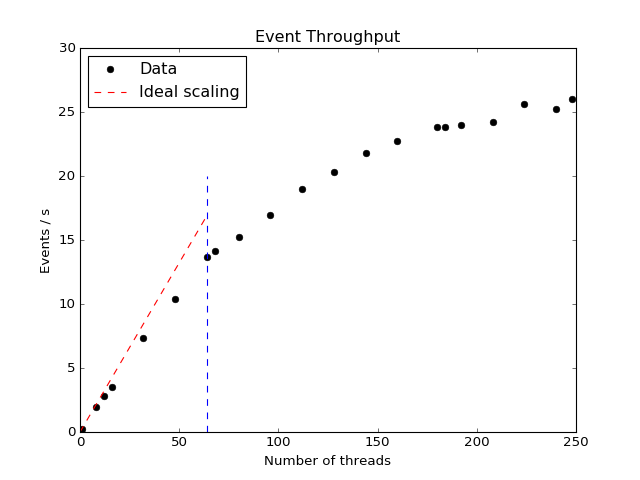

In [7]:
plt.figure()
plt.title('Event Throughput')
plt.plot(nThreads, thruPuts, 'ko', label='Data')
plt.xlabel('Number of threads')
plt.ylabel('Events / s')

# Draw ideal-scaling line, assuming 1-thread job as baseline
num_core = 64
ideal_threads = np.array([0, num_core])
ideal_thruput = ideal_threads * thruPuts[0]
plt.plot(ideal_threads, ideal_thruput, '--r', label='Ideal scaling')

# Draw vertical line at number of physical cores
cores_x, cores_y = [num_core, num_core], [0, 20]
plt.plot(cores_x, cores_y, '--b')

plt.legend(loc=2, numpoints=1);

In [11]:
#j = parse_job_result(mem_file='results_endeavour_1muNoOut/mem.248_0_248000.csv',
#                     time_file='results_endeavour_1muNoOut/timeline.248_0_248000.log')
j = [job for job in job_results if job.nThread == 248][0]

In [12]:
print_timing_summary([j])

Threads Events Job-time Init-time Loop-time Final-time
    248 248000  11702.0    1496.3   10167.0       38.8


In [13]:
print(get_throughput(j), get_avg_throughput(j))

24.3927167705 26.0105727931


In [23]:
# A color map for the algorithms
alg_color_map = {'SGInputLoader' : 'yellow',
                 'BeamEffectsAlg' : 'blue',
                 'G4AtlasAlg' : 'red',
                 'StreamHITS' : 'green',
                 #'AthOutSeq' : 'yellow',
                 #'AthRegSeq' : 'purple',
                }

class TimelineThreadData():
    """Simple struct for holding relevant timeline data in one thread"""
    def __init__(self, tid):
        self.tid = tid

def get_timeline_thread_data(job):
    """Get the processed timeline results per thread"""
    # Get the unique thread IDs
    tids = job.timeline_results['tids']
    unique_tids = np.unique(tids)
    assert(len(unique_tids) == job.nThread) # sanity check
    # Create and fill the per-thread timeline data
    ttds = [TimelineThreadData(tid) for tid in unique_tids]
    for ttd in ttds:
        indices = tids == ttd.tid
        algs = job.timeline_results['algs'][indices]
        ttd.colors = np.array([alg_color_map.get(alg, 'black') for alg in algs])
        starts = job.alg_starts[indices]
        durations = job.alg_durations[indices]
        ttd.times = np.column_stack((starts, durations))
    return ttds

def draw_timeline(tldata, figsize=(12, 6), num_thread=None, xmax=None, leg_loc=1):
    """Draw timeline plot from timeline thread data"""
    if num_thread is not None:
        tldata = tldata[:num_thread]
    nThreads = len(tldata)
    plt.figure(figsize=figsize)
    plt.title('Event loop timeline')
    bar_thickness = 0.8
    for i, t in enumerate(tldata):
        ylow = (i + 1.) - bar_thickness/2
        plt.broken_barh(t.times, [ylow, bar_thickness],
                        facecolors=t.colors, linewidth=0)
    # Fake bar objects to populate the legend
    legbars = [mpatch.Rectangle((0, 0), 1, 1, fc=c)
               for c in alg_color_map.values()]
    plt.xlabel('Event loop time [s]')
    plt.ylabel('Thread')
    plt.yticks(range(1, nThreads+1))
    plt.ylim(ymax=nThreads + 1.5)
    plt.xlim(xmin=0, xmax=xmax)
    plt.legend(legbars, alg_color_map.keys(), loc=leg_loc);

In [15]:
calc_alg_timings(j)
tldata_by_thread = get_timeline_thread_data(j)
print_timing_summary([j])
print('Throughput: %g events/s' % get_avg_throughput(j))

Threads Events Job-time Init-time Loop-time Final-time
    248 248000  11702.0    1496.3   10167.0       38.8
Throughput: 26.0106 events/s


<IPython.core.display.Javascript object>


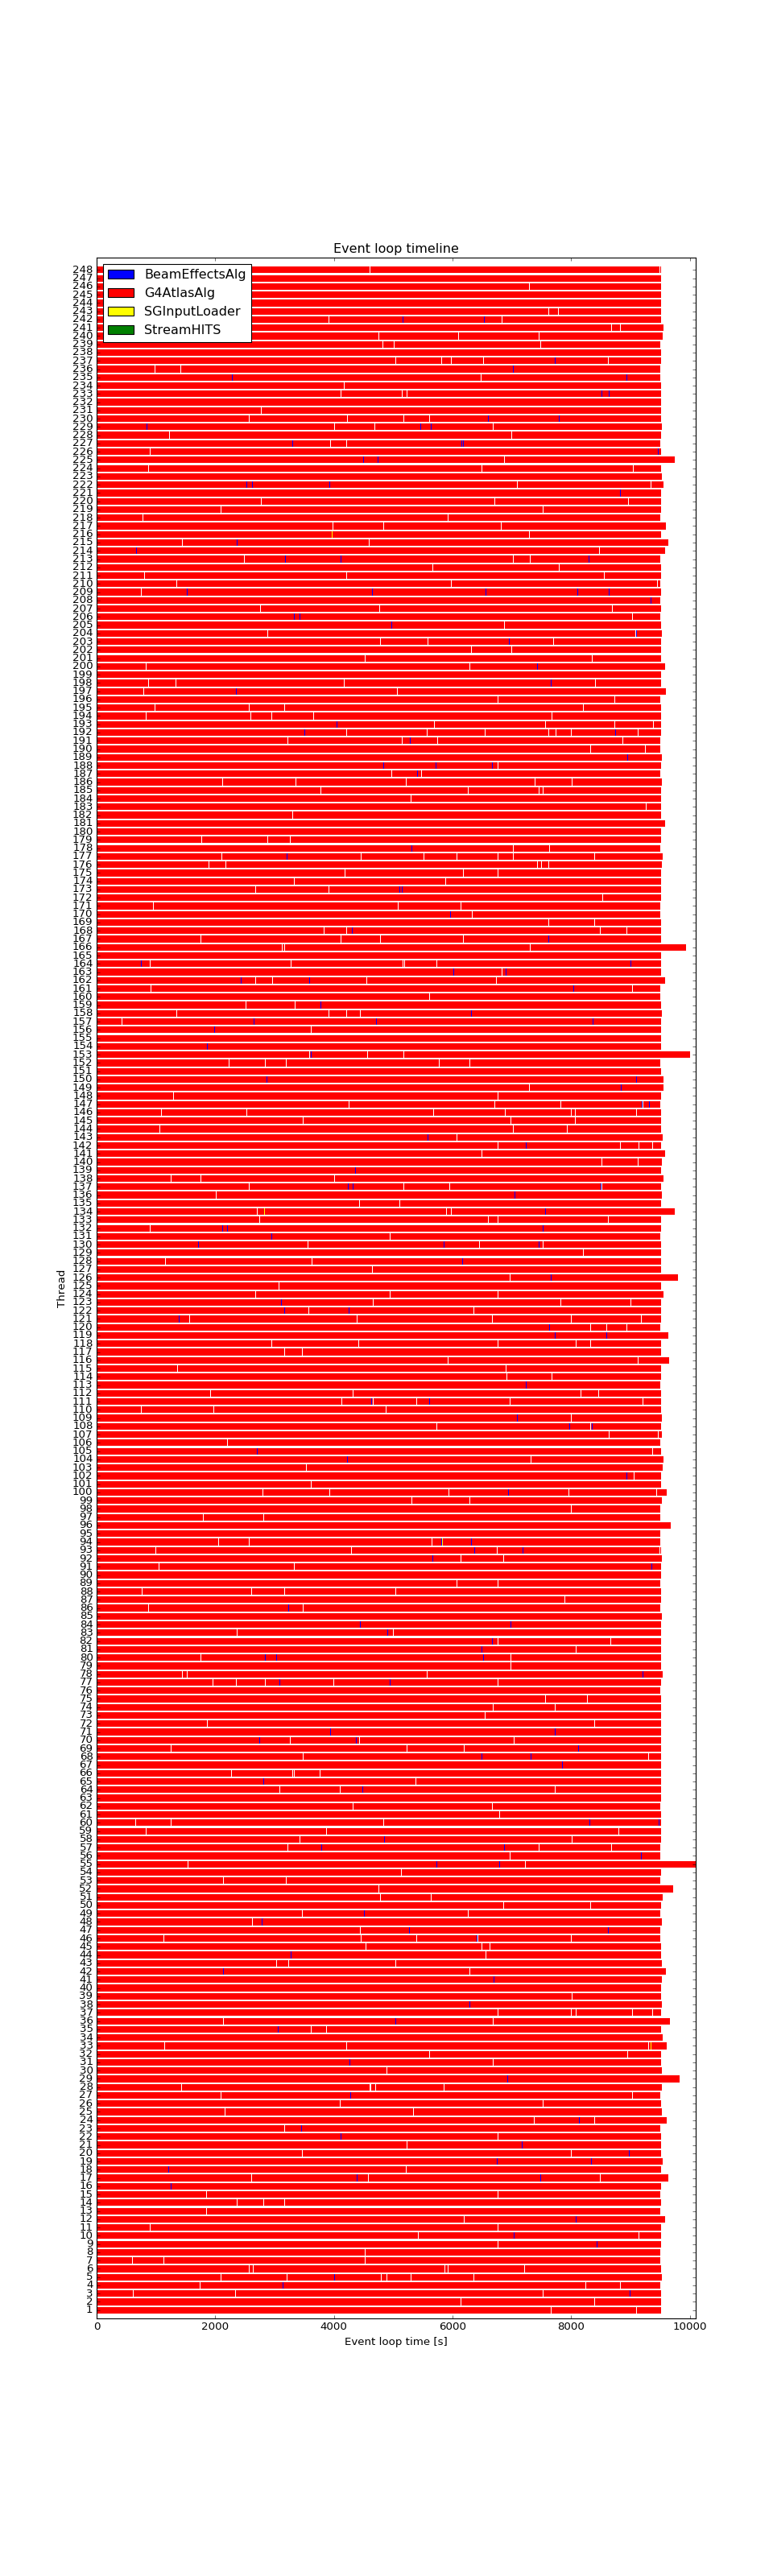

In [24]:
# Prepare the plot
draw_timeline(tldata_by_thread, (12, 40), leg_loc=2, xmax=10100)